In [87]:
import numpy as np
from numpy import unravel_index
import matplotlib.pyplot as plt
import random
from scipy.optimize import least_squares
import sys
from vector_class import TripleVector
from scipy.optimize import curve_fit



# Parameters

In [67]:
A_min = 1e3 # Bq
A_max = 2e3 # Bq
A_b = 5e-5 # Bq
h = 10 # m
dt = 100 # the pause on each point od the grid in s
x_max = 4; sigma_x = 0.1 # m
y_max = 4; sigma_y = 0.1 # m
grid = 8
n_bins = 20
K = 0.1 # is somewhere in the interval [0, 1]
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq

radiation = {"A_min": A_min, "A_max": A_max, "A_b": A_b, "dose_factor": F}
detector = {"h": h, "dt": dt, "x_max": x_max, "y_max": y_max, "grid": grid, "detector_constant": K} # the detector constant tells us the quality of the detector

n_points = 10 # fot the random_flyover() -> number of random points generated


## Flyover

In [97]:
 # it equals to the activity
def activity(source, x, y, h, ru=0, rv=0):
    u, v, A0 = source[0], source[1], source[2] # u, v are the coordinates of the source and A0 is its activity
    return (A0*(ru**2 + rv**2 + h**2)) / ((x - (u - ru))**2 + (y - (v - rv))**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

# Noise is a list that contanins the standard deviations of x/y coordinates as a result of the error of the detector
def flyover(radiation, detector, source = [], noise = []):
    A_min, A_max, A_b, F = radiation["A_min"], radiation["A_max"], radiation["A_b"], radiation["dose_factor"]
    h, dt, x_max, y_max, grid, K = detector["h"], detector["dt"], detector["x_max"], detector["y_max"], detector["grid"], detector["detector_constant"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid

    grid_x, grid_y = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    
    # If the source is not specified, then it is randomly generated 
    if len(source) == 0: 
        source = point_source(x_max, y_max, A_min, A_max)
    
    HDs = np.zeros((int(N_grid), int(N_grid))); dHDs = np.zeros((int(N_grid), int(N_grid)))
    n, m = N_grid - 1, 0
    y = -y_max + square_y/2
    i = 1
    for x in xs:
        while abs(y) <= y_max:
            A = activity(source, x, y, h)
            A_det = A * (1 - K)
            N = np.random.poisson(A_det * dt)
            N_b = np.random.poisson(A_b * dt)# background radiation

            # Add noise to the location data because of the GPS uncertianty
            if len(noise) != 0:
                sigma_x = noise[0]; sigma_y = noise[1]
                grid_x_noise[n, m] = x + np.random.normal(0, sigma_x)
                grid_y_noise[n, m] = y + np.random.normal(0, sigma_y)

            HDs[n, m] = F * (N + N_b)
            dHDs[n, m] = F * np.sqrt(N + N_b)
            
            grid_x[n, m] = x; grid_y[n, m] = y
            y += (square_y)*i
            n -= 1*i
        n += 1*i; i = i * (-1); y += (square_y)*i; m += 1
    i_max, j_max = unravel_index(HDs.argmax(), HDs.shape)
    x_c, y_c = grid_x[i_max, j_max], grid_y[i_max, j_max]
    maxI_range = {"xrange": (x_c - square_x/2, x_c + square_x/2), "yrange": (y_c - square_x/2, y_c + square_x/2)}

    return {"m_dose": HDs, "dm_dose": dHDs, "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "hotspot": maxI_range, "square_x": square_x, "square_y": square_y}

measurement = flyover(radiation, detector)

# hotspot = measurement["hotspot"]
# x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]



## Random flyover

In [99]:
# Flyover
# it equals to the activity
def activity(source, x, y, h, ru=0, rv=0):
    u, v, A0 = source[0], source[1], source[2] # u, v are the coordinates of the source and A0 is its activity
    return (A0*(ru**2 + rv**2 + h**2)) / ((x - (u - ru))**2 + (y - (v - rv))**2 + h**2)

def point_source(x_max, y_max, A_min, A_max, x_min=0, y_min=0):
    if (x_min == 0) and (y_min == 0):    
        return [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), random.uniform(A_min, A_max)]
    else:
        return [random.uniform(x_min, x_max), random.uniform(y_min, y_max), random.uniform(A_min, A_max)]

# Noise is a list that contanins the standard deviations of x/y coordinates as a result of the error of the detector
def random_flyover(n_points, radiation, detector, source = [], noise = []):
    A_min, A_max, A_b, F = radiation["A_min"], radiation["A_max"], radiation["A_b"], radiation["dose_factor"]
    h, dt, x_max, y_max, grid, K = detector["h"], detector["dt"], detector["x_max"], detector["y_max"], detector["grid"], detector["detector_constant"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    grid_x, grid_y = np.meshgrid(xs, np.flip(ys))
    grid_x_noise, grid_y_noise = np.zeros((N_grid, N_grid)), np.zeros((N_grid, N_grid))

    # If the source is not specified, then it is randomly generated 
    if len(source) == 0: 
        source = point_source(x_max, y_max, A_min, A_max)
    i = 0
    points = np.zeros((1, 4))
    while i < n_points:
        x = random.uniform(-x_max, x_max); y = random.uniform(-y_max, y_max)

        A = activity(source, x, y, h)
        A_det = A * (1 - K)
        N = np.random.poisson(A_det * dt)
        N_b = np.random.poisson(A_b * dt)# background radiation

        # Add noise to the location data because of the GPS uncertianty
        if len(noise) != 0:
            sigma_x = noise[0]; sigma_y = noise[1]
            x += np.random.normal(0, sigma_x)
            y += np.random.normal(0, sigma_y)

        HD = F * (N + N_b); dHD = F * np.sqrt(N + N_b)
        row = np.array([x, y, HD, dHD])
        points = np.vstack((points, row))          
        i += 1

    return {"points": points[1:, :], "source": source, "grid_x": grid_x, "grid_y": grid_y, "grid_x_noise": grid_x_noise, "grid_y_noise": grid_y_noise, "square_x": square_x, "square_y": square_y}

# Fit

def random_locationCF(measurement, detector):
    points = measurement['points']
    h, x_max, y_max = detector['h'], detector['x_max'], detector['y_max']

    XY = np.vstack((points[:, 0], points[:, 1]))
    HDs = points[:, 2]
    dHDs = points[:, 3]

    source0 = [random.uniform(-x_max, x_max), random.uniform(-y_max, y_max), 1]

    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs, source0, sigma = dHDs, absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict

# Combination

def random_combination(n_points, radiation, detector, source=[], noise=[]):
    measurement = random_flyover(n_points, radiation, detector, source, noise)
    sourceCF, stDev = random_locationCF(measurement, detector)[0], random_locationCF(measurement, detector)[1]
    return {'measurement': measurement, 'sourceCF': sourceCF, 'sourceCF_stDev': stDev}


# Visualization

def random_visualize(data):

    original = data['measurement']['source']
    estimate = data['sourceCF']
    measured = data['measurement']['points']

    plt.plot(original[0], original[1], "o", c="r", ms=10, label = "Original source")
    plt.plot(estimate[0], estimate[1], "o", c="k", ms=6, label = "Estimated source")
    plt.plot(measured[:, 0], measured[:, 1], "o", c="g", label = "Points of measurement")

    plt.xlabel('x axis [m]', fontsize=15)
    plt.xticks(fontsize=14)
    plt.ylabel('y axis [m]', fontsize=15)
    plt.yticks(fontsize=14)

    plt.legend()
    plt.show()

## Location from measurement - Levenberg-Marquardt method

### Scipy least square

In [4]:
# Using the Levenberg-Marquardt method with scipy least squares
def locationLM(measurement, radiation, detector):
    A_min, A_max = radiation['A_min'], radiation['A_max']
    h = detector['h']
    hotspot = measurement['hotspot']
    x_0, x_1 = hotspot['xrange']; y_0, y_1 = hotspot['yrange']

    def dose(source, x, y):
        u, v, alpha = source[0], source[1], source[2]
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    # def N(source, x, y):
    #     return N_func(source, x, y, h, dt)

    grid_x, grid_y = measurement['grid_x'], measurement['grid_y']
    HDs = measurement['m_dose']

    def fun(source):
        return (dose(source, grid_x, grid_y) - HDs).flatten()

    # guess = point_source(x_0, y_0, A_min, A_max, x_1, y_1)
    source0 = [1, 1, 1]
    res = least_squares(fun, source0, method="lm")

    return res["x"]

measurement = flyover(radiation, detector)
sourceLM = locationLM(measurement, radiation, detector)



### Scipy curve fit

In [5]:
# Also location with LM method, only now using the curve_fit scipy.optimize function 
def locationCF(measurement, radiation, detector, noise = []):
    HDs, dHDs, grid_x, grid_y, hotspot = measurement['m_dose'], measurement['dm_dose'], measurement['grid_x'], measurement['grid_y'], measurement["hotspot"] # in example Z, here Is
    grid_x_noise = measurement['grid_x_noise']; grid_y_noise = measurement['grid_y_noise']
    h = detector["h"]

    x_0, x_1 = hotspot["xrange"]; y_0, y_1 = hotspot["yrange"]

    if len(noise) == 0:
        XY = np.vstack((grid_x.ravel(), grid_y.ravel()))
    else:
        XY = np.vstack((grid_x_noise.ravel(), grid_y_noise.ravel()))
    source0 = [random.uniform(x_0, x_1), random.uniform(y_0, y_1), 1]
    
    def dose(x, y, u, v, alpha):
        return alpha / ((x - u)**2 + (y - v)**2 + h**2)

    def __dose(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += dose(x, y, *args[i*3:i*3+3])
        return arr

    popt, pcov = curve_fit(__dose, XY, HDs.ravel(), source0, sigma = dHDs.ravel(), absolute_sigma = True, method="lm")
    perr = np.sqrt(np.diag(pcov))
    

    MyDict = {"XY": XY, "Ns": HDs, "source0": source0}

    return popt, perr, MyDict


sourceCF = locationCF(measurement, radiation, detector)


### Standard deviation

In [6]:
def locationCFerror(measurement, radiation, detector):
    h = detector["h"]; dt = detector["dt"]
    dx = detector["dx"]; dy = detector["dy"]
    
    def intensity(x, y, u, v, A0): # it equals to the activity multiplied by the time of measuring u, v are the coordinates of the source and A0 
        return (A0*dt) / ((x - u)**2 + (y - v)**2 + h**2) # is its activity

    def _intensity(M, *args): # M is a table of shape (N, 2), where each row is a new point of measurement, N is the number of measuremnts
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += intensity(x, y, *args[i*3:i*3+3])
        return arr
    
    popt0, perr0 = locationCF(measurement, radiation, detector)[0], locationCF(measurement, radiation, detector)[1]
    u = popt0[0]; v = popt0[1]; A0 = popt0[2]
    du = perr0[0]; dv = perr0[1]; dA0 = perr0[2]

    MyDict = locationCF(measurement, radiation, detector)[2]
    XY = MyDict["XY"]; Is = MyDict["Is"]; source0 = MyDict["source0"]

    def stDev_I(x, y, u, v, A0):
        C = ((A0 * dt) / ((x-u)**2 + (x-v)**2 + h**2))
        return C * np.sqrt(4*(dx**2 + du**2)*(x - u)**2 + 4*(dy**2 + dv**2)*(y - v)**2 + (((x - u)**2 + (y - v)**2 + h**2)**2 / A0**2)*dA0**2)
    

    dIs = np.array([stDev_I(x, y, u, v, A0) for x in XY[0] for y in XY[0]])
    popt, pcov = curve_fit(_intensity, XY, Is.ravel(), sigma = dIs.ravel(), absolute_sigma=True)

    return popt, pcov

# print(locationCFerror(measurement, radiation, detector))


### TUTORIALS

#### Scipy least square minimization example  

In [7]:
def h(theta, x, y, h):
    return theta[2] * (x - theta[0])**2 + theta[3] * (y - theta[1])**2 - h

xs = np.linspace(-1, 1, 20)
ys = np.linspace(-1, 1, 20)
dt = 10
gridx, gridy = np.meshgrid(xs, ys)
x0 = 0.1; y0 = -0.15; a = 1; b = 2; noise = 0.1
hs = h([x0, y0, a, b], gridx, gridy, 10) * dt
# hs += noise * np.random.default_rng().random(hs.shape)

print(hs)

def fun(theta):
    return (h(theta, gridx, gridy, 10) * dt - hs).flatten()

theta0 = [0, 0, 1, 2]
res3 = least_squares(fun, theta0)

# print(hs)


[[-73.45       -75.65498615 -77.63836565 -79.4001385  -80.94030471
  -82.25886427 -83.35581717 -84.23116343 -84.88490305 -85.31703601
  -85.52756233 -85.51648199 -85.28379501 -84.82950139 -84.15360111
  -83.25609418 -82.13698061 -80.79626039 -79.23393352 -77.45      ]
 [-76.80734072 -79.01232687 -80.99570637 -82.75747922 -84.29764543
  -85.61620499 -86.71315789 -87.58850416 -88.24224377 -88.67437673
  -88.88490305 -88.87382271 -88.64113573 -88.18684211 -87.51094183
  -86.6134349  -85.49432133 -84.15360111 -82.59127424 -80.80734072]
 [-79.72146814 -81.92645429 -83.9098338  -85.67160665 -87.21177285
  -88.53033241 -89.62728532 -90.50263158 -91.15637119 -91.58850416
  -91.79903047 -91.78795014 -91.55526316 -91.10096953 -90.42506925
  -89.52756233 -88.40844875 -87.06772853 -85.50540166 -83.72146814]
 [-82.19238227 -84.39736842 -86.38074792 -88.14252078 -89.68268698
  -91.00124654 -92.09819945 -92.97354571 -93.62728532 -94.05941828
  -94.2699446  -94.25886427 -94.02617729 -93.57188366 -92.8

#### Scipy curve fit for 2D data example

<ipython-input-8-eb975bff86fc>:35: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


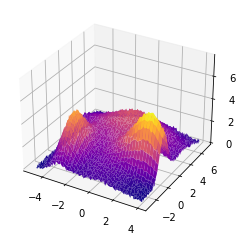

Fitted parameters:
[-0.00611277  1.99506645  2.51503141  5.38704605  1.50628455 -1.00574151
  4.00087266  6.00928878  2.51148791  1.79275702 -3.00226604 -0.50641025
 -0.99422313  1.98908729  4.00515019  2.99340093  0.4993757   1.99262828
  0.99963307  4.99216303]
RMS residual = 0.09886958622691884


<ipython-input-8-eb975bff86fc>:75: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


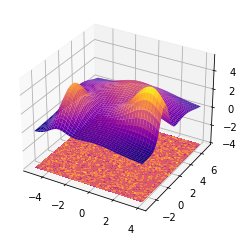

In [8]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The two-dimensional domain of the fit.
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape) # In our example this are the measured intesities Is

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr

# Initial guesses to the fit parameters.
guess_prms = [(0, 0, 1, 1, 2),
              (-1.5, 5, 5, 1, 3),
              (-4, -1, 1.5, 1.5, 6),
              (4, 1, 1.5, 1.5, 6.5)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(popt)//5):
    fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit, cmap='plasma')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()



## Combine

In [70]:
def const(K, F):
    return F / (1 - K)

# combines the detector flyover and the location detection
def combination(radiation, detector, source=[], noise=[]):
    measurement = flyover(radiation, detector, source, noise)
    sourceLM = locationLM(measurement, radiation, detector)
    sourceCF, stDev = locationCF(measurement, radiation, detector, noise)[0], locationCF(measurement, radiation, detector, noise)[1]
    return {'measurement': measurement, 'source_locationLM': sourceLM, 'source_locationCF': sourceCF, "sourceCF_stDev": stDev}

data = combination(radiation, detector, [], [])





In [10]:
def radioactive_dose(C, Dt, data):
    A0 = data['source_locationCF'][2]
    Hd = C * A0 * Dt
    rel_Hd = 1/np.sqrt(Hd/C)
    return {"Hd": Hd, "rel_Hd": rel_Hd}

det1 = radioactive_dose(1e6, 100, data)
det2 = radioactive_dose(1e8, 100, data)

print(det1, "\n", det2)


{'Hd': 232649903341232.53, 'rel_Hd': 6.556145175675171e-05} 
 {'Hd': 2.3264990334123252e+16, 'rel_Hd': 6.556145175675171e-05}


## Visualization

C:\Users\urhtr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
C:\Users\urhtr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


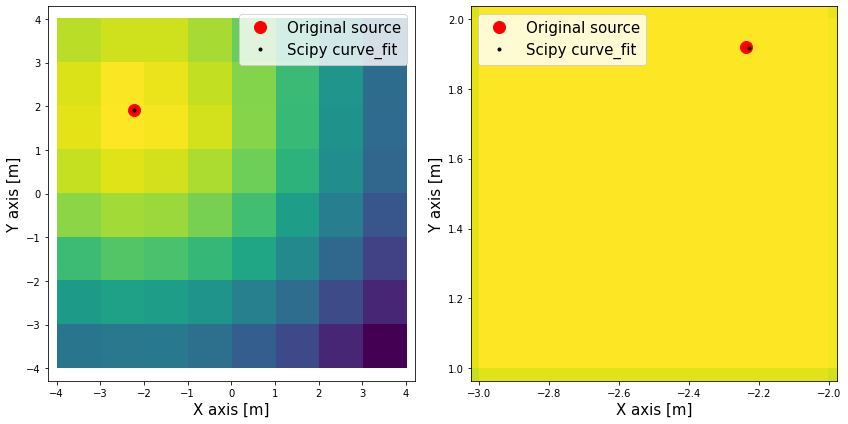

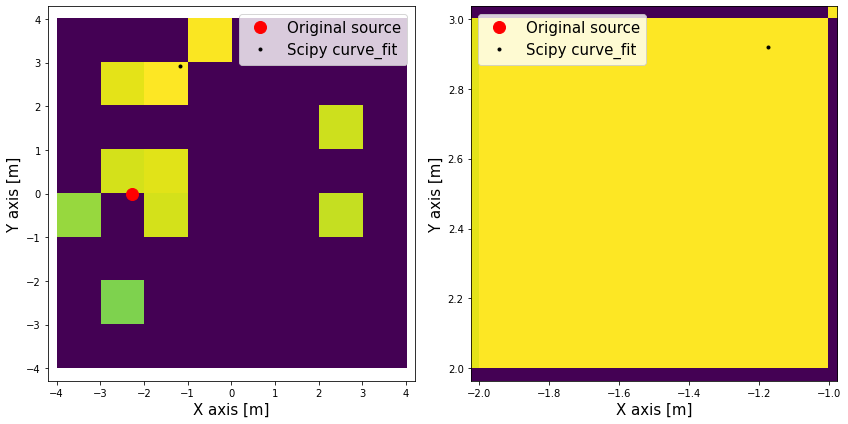

In [72]:
def visualize(measurement, x_max, y_max, points):
    X, Y = measurement['source'][0], measurement['source'][1]
    u1, v1 = points[0][0], points[0][1]
    u2, v2 = points[1][0], points[1][1]
    # print((u1, v1), (u2, v2))

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    
    im = ax1.imshow(measurement['m_dose'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax1.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    # ax1.plot(u1, v1, "o", color = 'g', ms=6, label = "Scipy least_square")
    ax1.plot(u2, v2, "o", color = 'k', ms=3, label = "Scipy curve_fit")

    ax1.axis("equal")
    ax1.set_xlabel("X axis [m]", fontsize = 15)
    ax1.set_ylabel("Y axis [m]", fontsize = 15)
   
    ax1.legend(fontsize = 15)

    hotspot = measurement['hotspot']
    x_0, x_1 = hotspot['xrange']; y_0, y_1 = hotspot['yrange']

    ax2.imshow(measurement['m_dose'], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    ax2.plot(X, Y, "o", color = 'r', ms=12, label = "Original source")
    # ax2.plot(u1, v1, "o", color = 'g', ms=6, label = "Scipy least_square")
    ax2.plot(u2, v2, "o", color = 'k', ms=3, label = "Scipy curve_fit")
    ax2.axis("equal")
    ax2.set_xlim(x_0, x_1)
    ax2.set_xlabel("X axis [m]", fontsize = 15)
    ax2.set_ylim(y_0, y_1)
    ax2.set_ylabel("Y axis [m]", fontsize = 15)

   
    ax2.legend(fontsize = 15)    

    plt.tight_layout()
    # plt.savefig("graphics/imporved.jpg")
    plt.show()
    # return points[1]
    # print(measurement["intensities_array"], '\n', measurement["grid_x"], '\n', measurement["grid_y"])

# 0.1, 0.1, 100
data = combination(radiation, detector, [], [])
data_random = random_combination(n_points, radiation, detector, [], [])

visualize(data['measurement'], detector['x_max'], detector['y_max'], [data['source_locationLM'], data['source_locationCF']])
visualize(data_random['measurement'], detector['x_max'], detector['y_max'], [data_random['source_locationLM'], data_random['source_locationCF']])


## Analysis

### Standard deviation

In [12]:
def dist_points(point1, point2):
    return (point1 - point2).magnitude()

# run simulation n_sim times and keep track of the distance between the original source and estimated source. Plot a histogram for the values.
def stDev(radiation, detector, n_sim):
    R = []
    for i in range(n_sim):
        data = combination(radiation, detector)
        original = (data["measurement"])["source"]
        estimate = data["source_locationLM"]
        R.append(dist_points(TripleVector(original[0], original[1], 0), TripleVector(estimate[0], estimate[1], 0)))
 
    plt.hist(np.array(R), 100)
    plt.xlabel("r error [m]", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("number of values", fontsize = 15)
    plt.yticks(fontsize = 15)

    #plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    # plt.savefig("graphics/dr_hist.jpg")
    plt.show()

    d_R = np.std(R)

    return d_R

n_sim = 1000
# print(stDev(radiation, detector, n_sim))

# Code description

u = -34.21186836981083 ± 0.553063884499491 m
v = 19.020131215685105 ± 0.6578529295439123 m
alpha = 1075582.6378866115 ± 10421.203178190332 


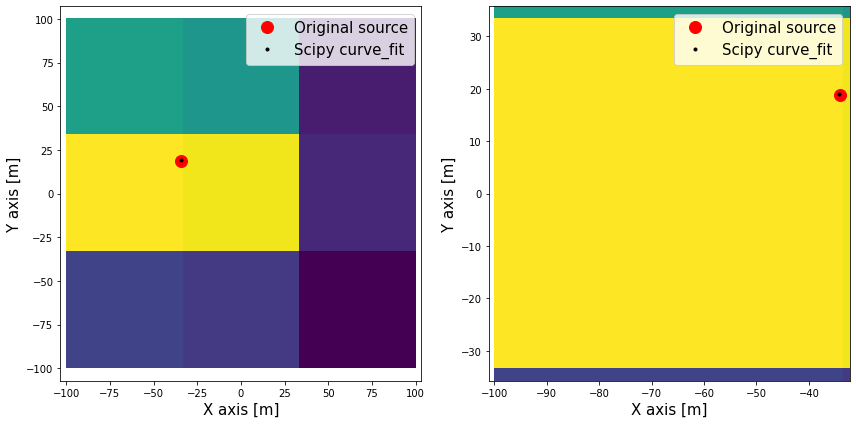

u = -33.552951867890265 ± 0.6104458742928024 m
v = 19.270749495703804 ± 0.6907030891668108 m
alpha = 1093982.1468895467 ± 10808.903153943396 


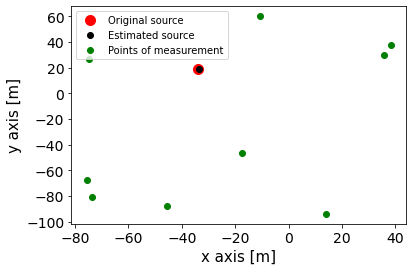

In [108]:
# DESCRIPTION OF THE CODE

# In comparisson to the code in simple_SPS.ipynb there are a few minor changes. The intensity function is defined diferently. It takes into
# consideration two points, the source of the radiation and the position of a measurement. Flyover() is very similar to the older version 
# it just uses the new intensity and also the activity of the source is randomly generated - it is one of the parameters which we are fitting.

# locationLM() is the major chenge. We use the scipy least square Levenberg-marquardt method to minimize the square residuals of the model 
# intensity and the measured intensity. Through the minimization we can output the paramaters which we are searching for - u, v and A0 (x/y 
# coordinates of the source and its intensity).

# visualize() shows us that this method is much more accurate then the previously used location searching method.

# PARAMETERS
A_min = 1e3; A_max = 1.5e3 # borders between which the activity of the source is randomly selected 
A_b = 5e-5 # background activity in Bq
h = 40 # hight at which the detector flies over in m
x_max = 100 # Size of the area of flyover in positive x direction in m (the whole grid extends also in the negative direction the same amount)
y_max = 100 # Size of the area of flyover in positive y direction in m (the whole grid extends also in the negative direction the same amount)
grid = 3 # Size of the grid in which the area of flyover is divided into smaller "tiles" where the detector stops and measures the number of 
         # radioactive decays. Grid is the number of these areas in x direction and y direction. It must be an INTEGER!
dt = 10 # the pause on each point od the grid in s
noise = [5, 5] # list that contains the standard deviation of the x and y coordinates in in m
K = 0.6 # constant between 0 and 1 which contains the information on the quality of the detector, a better detector has a smaller constante 
        # then then an inferior detector
F = 0.140 # factor for inhilation of Pu-239 in mSV/Bq
n_points = 9 # number of points randomlly selected in the grid


# Combinig the parameters into a list so that the data is more compacted
radiation = {'A_min': A_min, 'A_max': A_max, 'A_b': A_b, 'dose_factor': F}
detector = {'h': h, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid, 'detector_constant': K}

# Flying over the surface
data = combination(radiation, detector, [-34.06413743466325, 18.72494667983291, 1207.4224164766233], [])
# print(data["sourceCF_stDev"])
# Print out the fitted parameters with their absolute errors (standard deviation)
print("u =", data["source_locationCF"][0], r'±', data["sourceCF_stDev"][0], "m")
print("v =", data["source_locationCF"][1], r'±', data["sourceCF_stDev"][1], "m")
print("alpha =", data["source_locationCF"][2], r'±', data["sourceCF_stDev"][2], "")

visualize(data["measurement"], detector["x_max"], detector["y_max"], [data["source_locationLM"], data["source_locationCF"]])

# Random points over the surface
data_random = random_combination(n_points, radiation, detector, [-34.06413743466325, 18.72494667983291, 1207.4224164766233], [])
print("u =", data_random["sourceCF"][0], r'±', data_random["sourceCF_stDev"][0], "m")
print("v =", data_random["sourceCF"][1], r'±', data_random["sourceCF_stDev"][1], "m")
print("alpha =", data_random["sourceCF"][2], r'±', data_random["sourceCF_stDev"][2], "")

random_visualize(data_random)



### Detector constant analysis

#### Comparisons

In [14]:
testSource = point_source(x_max, y_max, A_min, A_max)
testSource1 = point_source(x_max, y_max, A_min, A_max)
testSource2 = point_source(x_max, y_max, A_min, A_max)
testSource

[-45.22342561235115, -24.606405657397403, 1168.3523395982056]

In [15]:
# change the grid so that with a grid with more tiles the worse detector can get similar error to the first one
grid0, grid2 = 10, 20
h0 = 40; h1 = 30; h2 = 100 
noise = [1, 1]

# Analysis for detectors without noise, detector0 is an ideal detector and detector1 is a superior real detector to the real detector2
detector0 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid2, 'detector_constant': 0.}
detector1 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid2, 'detector_constant': 0.1}
detector2 = {'h': h0, 'dt': dt, 'x_max': x_max, 'y_max': y_max, 'grid': grid2, 'detector_constant': 0.8}    

# We generate the data measurement and analysis for the same source, same grid and everything, the only difference between the detectors is K
data0 = combination(radiation, detector0, testSource, noise)
data1 = combination(radiation, detector1, testSource, noise)
data2 = combination(radiation, detector2, testSource, noise)

# Estimated source positions (with errors) 
u0, du0 = data0["source_locationCF"][0], data0["sourceCF_stDev"][0]; v0, dv0 = data0["source_locationCF"][1], data0["sourceCF_stDev"][1] 
u1, du1 = data1["source_locationCF"][0], data1["sourceCF_stDev"][0]; v1, dv1 = data1["source_locationCF"][1], data1["sourceCF_stDev"][1]
u2, du2 = data2["source_locationCF"][0], data2["sourceCF_stDev"][0]; v2, dv2 = data2["source_locationCF"][1], data2["sourceCF_stDev"][1]

# The (u, v) ± (du, dv)
print("DETECTOR0:", "\n", (u0, v0), r'±', (du0, dv0), "m")
print("DETECTOR1:", "\n", (u1, v1), r'±', (du1, dv1), "m")
print("DETECTOR2:", "\n", (u2, v2), r'±', (du2, dv2), "m")


DETECTOR0: 
 (-45.262510818075526, -24.44862368865471) ± (0.0648417084600959, 0.06154186428464738) m
DETECTOR1: 
 (-45.16395360940904, -24.50453301371698) ± (0.06788708161461236, 0.06466001904920199) m
DETECTOR2: 
 (-45.6717408013334, -24.732370966442847) ± (0.14487288748354854, 0.13693634409015237) m


#### Comparisons between detectors

[4, 16, 36, 64, 100, 144, 196, 256, 324, 400, 529, 625, 729, 841, 961, 1089, 1225, 1369, 1521, 1764] 
 [0.02378322001671941, 0.009621713141609773, 0.008885466304335376, 0.00644163663393422, 0.004486524713772992, 0.003445195105022032, 0.0034674036107469014, 0.002874506537216627, 0.0025924653204134605, 0.00235300915823898, 0.002051250960344933, 0.001882832014828899, 0.0017152985051725128, 0.0015299473036588947, 0.0014071344521927106, 0.0013874801808770863, 0.001256985876657072, 0.0012358223010719555, 0.001131726234272837, 0.0010650428232765752] 
 [0.04156180016451386, 0.010053726337311275, 0.007551170313753073, 0.005577958780067432, 0.004522451202811444, 0.0037485461031884133, 0.0032353820347843635, 0.0028254260077377456, 0.0024936622907715525, 0.0022585979571475446, 0.0019603469421477773, 0.001806373813584585, 0.0016710667960554214, 0.0015574105958889957, 0.001457114100644803, 0.001367589793838151, 0.0012924650516522003, 0.0012226245392708422, 0.0011563128838494414, 0.001073415526737089

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

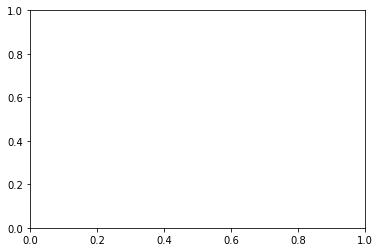

In [115]:
# errors compared to detectors with different grid, heights and qualities

def compK(radiation, detector, source, noise= []):
    Ks = np.linspace(0, 0.8, 20)
    dus = []
    dvs = []
    for K in Ks:
        detector['detector_constant'] = K 
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0]/abs(data['source_locationCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['source_locationCF'][1]))
    draw(Ks, [dus, dvs], "Coefficient of the detector, K []", "Relative error []")

def compH(radiation, detector, source, noise= []):
    hs = np.linspace(10, 100, 20)
    dus = []
    dvs = []
    for h in hs:
        detector['h'] = h
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0]/abs(data['source_locationCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['source_locationCF'][1]))
    draw(hs, [dus, dvs], "Height of flyover [m]", "Relative error []")

def compG(radiation, detector, source, noise = []):
    grids = np.linspace(2, 42, 20)
    dus = []
    dvs = []
    for grid in grids:
        detector['grid'] = int(grid)
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0]/abs(data['source_locationCF'][0]))
        dvs.append(data['sourceCF_stDev'][1]/abs(data['source_locationCF'][1]))
    draw(grids, [dus, dvs], "Number of grid points []", "Absolute error [m]")

def compT(radiation, detector, source, noise = []):
    dts = np. linspace(1, 1000, 20)
    dus = []
    dvs = []
    for dt in dts:
        detector['dt'] = dt
        data = combination(radiation, detector, source, noise)
        dus.append(data['sourceCF_stDev'][0])
        dvs.append(data['sourceCF_stDev'][1])
    draw(dts, [dus, dvs], "Time of measurement at each grid point [s]", "Absolute error [m]")

def comp_randToG(radiation, detetctor, source, noise = []):
    grids = np.linspace(2, 42, 20)
    dus_R = []; dus_G = []; measured_points = []
    for grid in grids:
        detector['grid'] = int(grid); n_points = int(grid)**2
        measured_points.append(n_points)
        data_R = random_combination(n_points, radiation, detector, source, noise)
        dus_R.append(data_R['sourceCF_stDev'][0]/abs(data_R['sourceCF'][0]))
        data_G = combination(radiation, detector, source, noise)
        dus_G.append(data_G['sourceCF_stDev'][0]/abs(data_G['source_locationCF'][0]))
    print(measured_points, "\n", dus_R, "\n", dus_G)

    plt.plot(measured_points, data_R, "o", label = "Random")

    plt.xlabel("Measured points", fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel("Measured points", fontsize = 15)
    plt.yticks(fontsize = 14)

    # plt.savefig("graphics/err_to_K.png")
    plt.legend()
    plt.show()

def draw(xs, ys, name_x = "", name_y = ""):
    plt.plot(list(xs), ys[0], "o", label = "u-error")
    if len(ys) == 2:
        plt.plot(list(xs), ys[1], "o", label = "v-error")

    plt.xlabel(name_x, fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.ylabel(name_y, fontsize = 15)
    plt.yticks(fontsize = 14)

    # plt.savefig("graphics/err_to_K.png")
    plt.legend()
    plt.show()
    


# compK(radiation, detector0, testSource)
# compH(radiation, detector0, testSource)
# compG(radiation, detector0, testSource)
comp_randToG(radiation, detector0, testSource)



# Comment: the uncertianty increasies with the detector coefficient.


#### Comparison for testSource at each grid point 

40.0
[-95.16506227655346, -65.50880022826266, 1346.4211255228838]


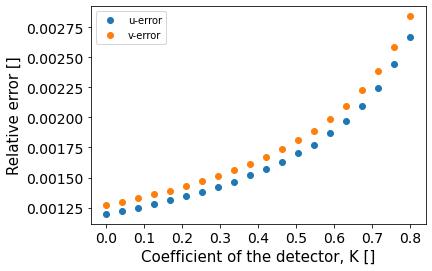

[-92.56712192281692, -30.026055423013215, 1373.705481576917]


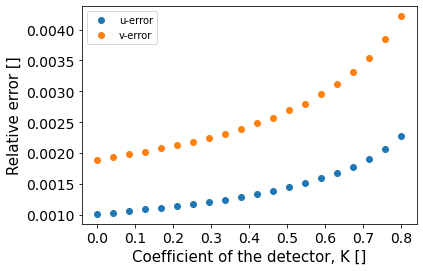

[-79.03384022230637, -19.406699101820784, 1180.3124679768544]


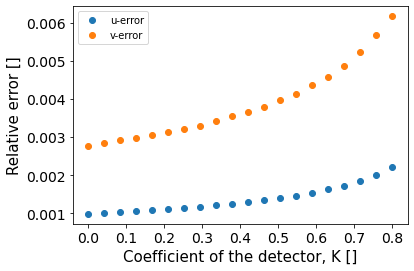

[-88.60117959538034, 29.03679928140147, 1022.0728097354545]


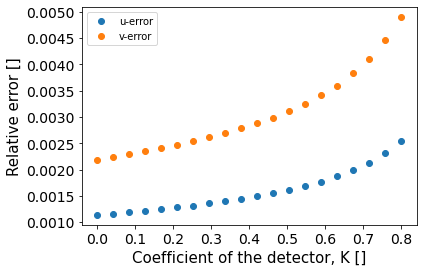

[-89.86709234486463, 79.80176964187683, 1426.7170753685314]


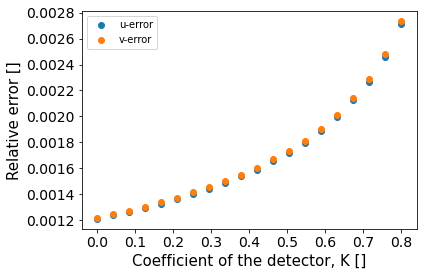

[-58.34836122137263, -62.37390145598503, 1133.4473578856014]


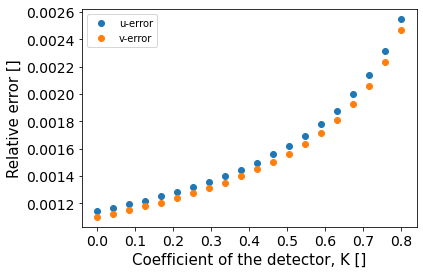

[-20.348964010287553, -34.99865392902967, 1455.6144744530238]


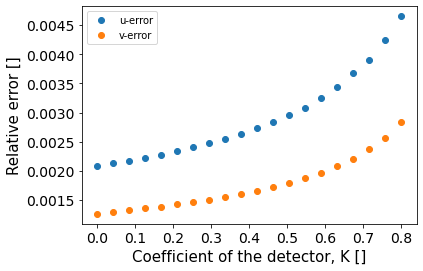

[-43.80549125153883, 15.563579807750187, 1218.3902485227559]


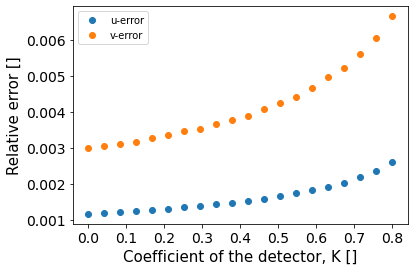

[-59.361061186575924, 50.75855472118512, 1396.2361391194568]


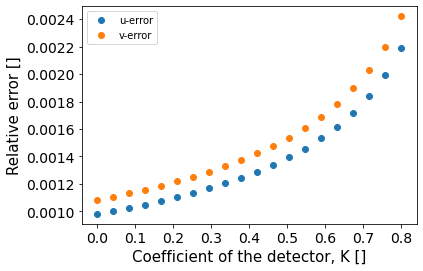

[-37.66039632283914, 84.98070684990327, 1318.848127116]


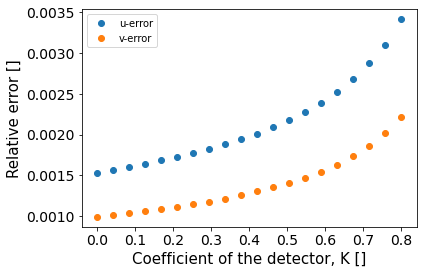

[11.514417338401188, -84.89217169824147, 1003.066061076082]


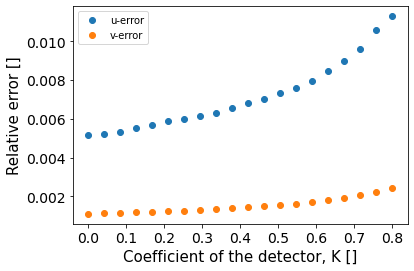

[0.37964864044276325, -56.7293731300218, 1219.2659629106658]


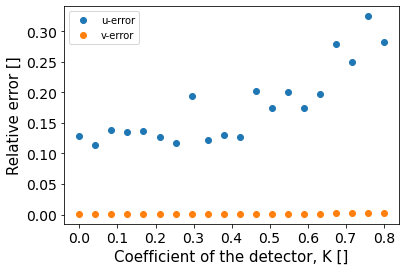

[0.4271626599824607, 17.705854402507995, 1121.5603294908915]


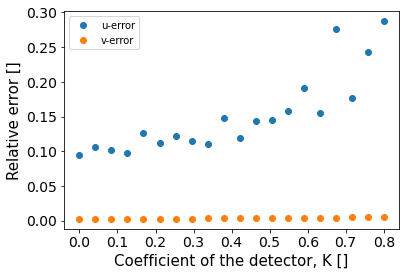

[18.476751127688097, 39.25222991131681, 1425.6585736046825]


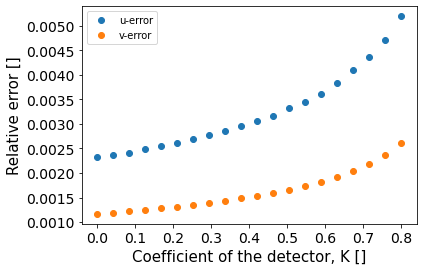

[10.809282597097539, 77.13117456251663, 1018.7040771585372]


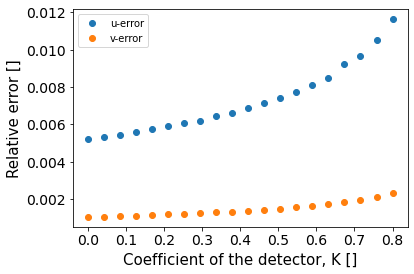

[59.765787605493394, -65.93642564588565, 1180.6084192143037]


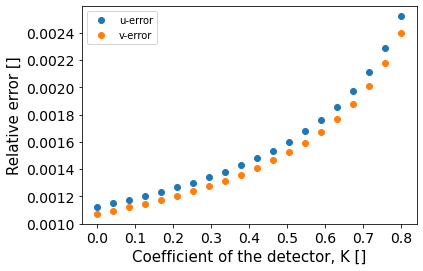

[58.22743773431197, -52.40424038661792, 1191.017660365864]


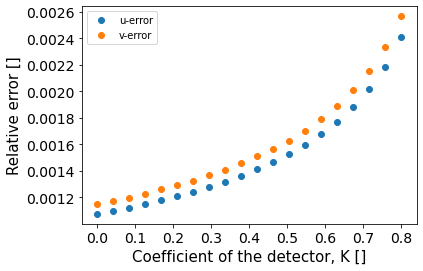

[53.36949821461593, -6.399017884603936, 1491.7571424845237]


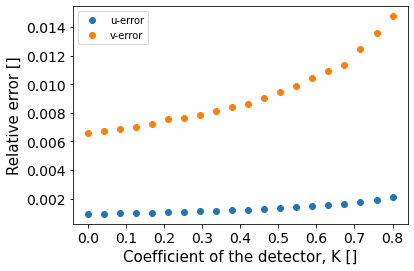

[24.529786478176696, 52.30004229554805, 1345.516068753124]


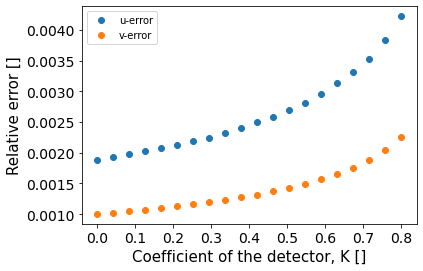

[42.01148007464914, 85.40188580117878, 1170.1872773680657]


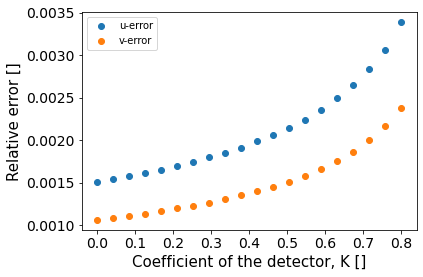

[85.5085790094514, -82.81501038282525, 1019.2073158162482]


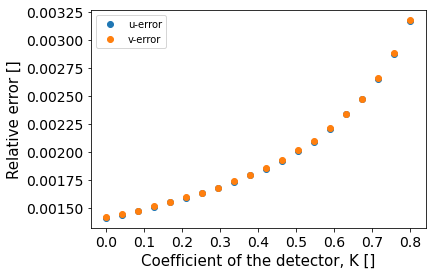

[66.01293852566134, -49.61984903173967, 1412.4821466373278]


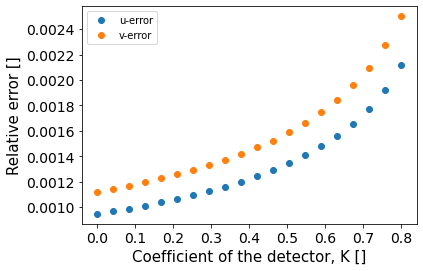

[75.03735030341971, -17.34518008256839, 1008.6139677987643]


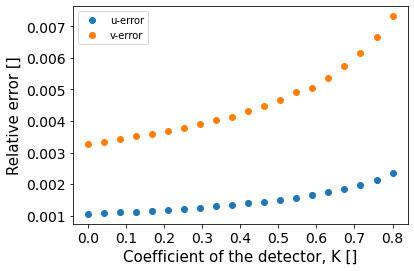

[76.02662181251472, 29.260536663548145, 1108.147481404114]


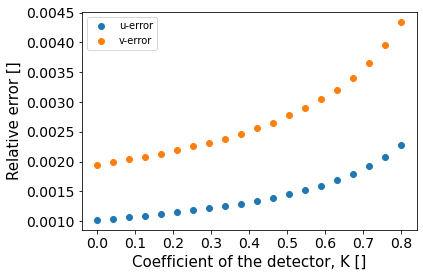

[99.44248651845851, 92.98164078844707, 1393.6927515411708]


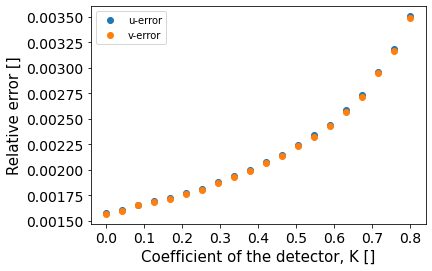

In [35]:

def loopOverGrid(radiation, detector):
    A_min, A_max = radiation["A_min"], radiation["A_max"]
    x_max, y_max, grid = detector["x_max"], detector["y_max"], detector["grid"]
    N_grid = grid
    square_x, square_y = (2*x_max)/N_grid, (2*y_max)/N_grid
    xs = np.linspace(-x_max + square_x/2, x_max - square_x/2, int(N_grid))
    ys = np.linspace(-y_max + square_y/2, y_max - square_y/2, int(N_grid))
    print(square_x)
    for x in xs:
        for y in ys:
            testSource = point_source(x + square_x/2, y + square_y/2, A_min, A_max, x - square_x/2, y - square_y/2)
            print(testSource)
            compK(radiation, detector0, testSource, [])
            # input('press enter')

loopOverGrid(radiation, detector)


#### By way of fitting?

In [17]:
# For a range of detector factors from 0 to 1, find the A(K) = ED(K)/ED0

def factor_fit(radiation, detector, testSource1, testSource2):
    K_range = np.linspace(0.01, 0.99, 10)
    data01 = combination(radiation, detector, testSource1, noise); data02 = combination(radiation, detector, testSource2, noise)
    ED01 = data01['effective_dose'][0]; ED02 = data02['effective_dose'][0]
    As1, As2 = [], []
    for K in K_range:
        detector['detector_constant'] = K
        data1 = combination(radiation, detector, testSource1, noise); data2 = combination(radiation, detector, testSource2, noise)
        ED1 = data1['effective_dose'][0]; ED2 = data2['effective_dose'][0]
        A1 = ED1/ED01; A2 = ED2/ED02
        print(A1)
        As1.append(A1)
        As2.append(A2)
    plt.plot(list(K_range), As1, "o", color="b", ms=10)
    plt.plot(list(K_range), As2, "o", color="g", ms=9)

    plt.xlabel("detector coeficient")
    plt.ylabel("A(K)")

    plt.show()


factor_fit(radiation, detector0, testSource1, testSource2)


KeyError: 'effective_dose'

#### Relation between error and grid

<ipython-input-17-0b9964a09a21>:2: RuntimeWarning: invalid value encountered in sqrt
  return ((A / np.sqrt(B * (x))) + C)


[ 1.58332565e+00  4.58697670e+01 -2.25776432e-02] ± [1.06612082e+06 6.17721492e+07 1.01411163e-03]


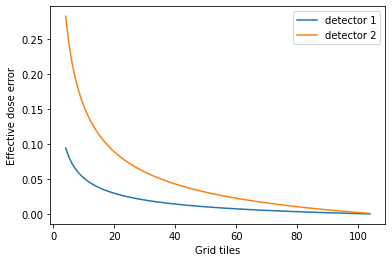

In [ ]:
def func(x, A, B, C):
    return ((A / np.sqrt(B * (x))) + C) 
    
def fit(xs, ys):
    popt, pcov = curve_fit(func, xs, ys, [5.93223505, 70, -0.07433773], method="lm")
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def errToGrid(radiation, detector1, detector2, testSource):
    errs1, errs2 = [], []
    grids = np.linspace(4, 104, 100)
    for grid in grids:
        detector1["grid"] = int(grid)
        detector2["grid"] = int(grid)
        data1 = combination(radiation, detector1, testSource, []); data2 = combination(radiation, detector2, testSource, [])
        errs1.append(data1["effective_dose"][1]); errs2.append(data2["effective_dose"][1])
    
    popt1, perr1 = fit(grids, errs1); popt2, perr2 = fit(grids, errs2)
    print(popt1, r'±', perr1)

    # plt.plot(grids, np.array(errs1), "o")
    plt.plot(grids, np.array([func(grid, *popt1) for grid in grids]), "-", label="detector 1")
    # plt.plot(grids, np.array(errs2), "o")
    plt.plot(grids, np.array([func(grid, *popt2) for grid in grids]), "-", label="detector 2")

    plt.xlabel("Grid tiles")
    plt.ylabel("Effective dose error")

    plt.legend()
    plt.show()

errToGrid(radiation, detector1, detector2, testSource)
